# Time-Dependent Variational Principle (TDVP)
This notebook demonstrates the capabilities of our implemented TDVP algorithm, if the underlying tensor network structure is a chain, i.e. in matrix product form. A matrix product state (MPS) is a binary tree. Therefore, we can simulate it using `PyTreeNet`. We recommend to use tensor network libraries specialised on MPS for serious simulation, due to a higher efficiency. However, utilising `PyTreeNet` on MPS is useful as an illustrative example and to test the code for mistakes, by comparing to the results yielded by the easy to implement few-site dynamics.

In [1]:
from copy import deepcopy

# Import PyTreeNet from local folders
import sys
sys.path.append('..')
import pytreenet as ptn

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

In [2]:
X, Y, Z = ptn.common_operators.pauli_matrices()
time_step_size = 0.001
final_time = 1
eval_time = 10

## TDVP: A single qubit rotation on a Bloch Sphere
We use a simple Hamiltonian $H=X$ on a single qubit that is initially in the zero state $\ket{\psi} = \ket{0}$.

In [3]:
state = ptn.TreeTensorNetworkState()
tensor = np.array([1,0],dtype=complex)
single_node = ptn.Node(identifier="qubit")
state.add_root(single_node,tensor)
print(state.nodes)
print(state.tensors)

{'qubit': <pytreenet.node.Node object at 0x7fa580374d90>}
{'qubit': array([1.+0.j, 0.+0.j])}


In [4]:
ham = ptn.TTNO()
single_ham_node = ptn.Node(identifier="qubit")
ham.add_root(single_ham_node, deepcopy(X))
print(ham.nodes)
print(ham.tensors)

{'qubit': <pytreenet.node.Node object at 0x7fa580374d30>}
{'qubit': array([[0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j]])}


Then we set up the TDVP algorithm.

In [5]:
operators = ptn.TensorProduct({"qubit": Z})

In [6]:
tdvp = ptn.FirstOrderOneSiteTDVP(state, ham,time_step_size, final_time,
                                 operators)
tdvp.run(evaluation_time=eval_time)
# Sanity checks
print(tdvp.results_real())
print(tdvp.operator_results().shape)

100%|██████████| 1001/1001 [00:00<00:00, 4857.38it/s]

True
(1, 101)


Now we run an exact reference computation:

In [7]:
ref_state = np.array([1,0],dtype=complex)
ref_ham = X
operator = Z
exact_evo = ptn.ExactTimeEvolution(ref_state, ref_ham,
                                   time_step_size, final_time,
                                   operator)
exact_evo.run(evaluation_time=eval_time)
# Sanity checks
print(exact_evo.results_real())
print(exact_evo.operator_results().shape)

100%|██████████| 1001/1001 [00:00<00:00, 477047.87it/s]

True
(1, 101)


In [8]:
times = tdvp.times()
ref_results = exact_evo.operator_results(realise=True)[0]
tdvp_results = tdvp.operator_results(realise=True)[0]

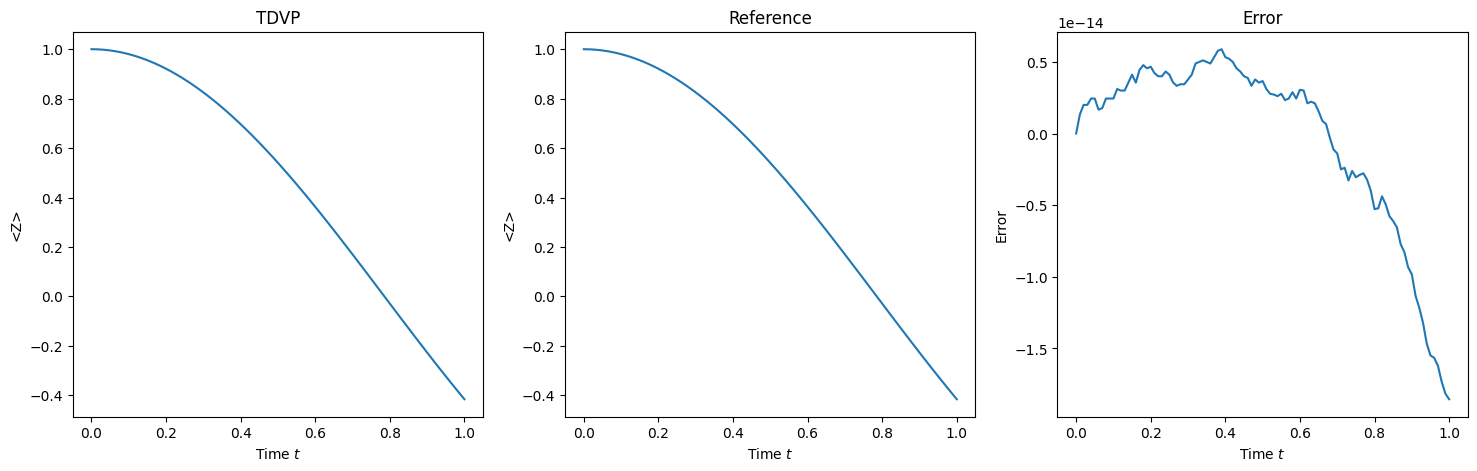

In [9]:
fig1, axs1 = plt.subplots(1,3, sharex=True, figsize=(18,5))
axs1[0].plot(times, tdvp_results)
axs1[0].set_xlabel("Time $t$")
axs1[0].set_ylabel("<Z>")
axs1[0].set_title("TDVP")

axs1[1].plot(times, ref_results)
axs1[1].set_xlabel("Time $t$")
axs1[1].set_ylabel("<Z>")
axs1[1].set_title("Reference")

axs1[2].plot(times, ref_results - tdvp_results)
axs1[2].set_xlabel("Time $t$")
axs1[2].set_ylabel("Error")
axs1[2].set_title("Error")

plt.show()

# TDVP with MPS: Two Qubit system evolving under Heisenberg Hamiltonian
This time we consider the Heisenberg like Hamiltonian on two qubits given by
$$
H = -J X_0X_1 -g (Z_0 + Z_1),
$$
where $X_i$ and $Z_i$ are the Pauli operators acting on qubit $i$. We start in the zero state
$$
\ket{\psi} = \ket{0}_0 \otimes \ket{0}_1.
$$

In [10]:
num_sites = 2
mJ = 1.5
mg = 0.5

In [11]:
mps_2_site = ptn.MatrixProductState.constant_product_state(0,2,num_sites,
                                                           bond_dimensions=[1])
print(mps_2_site.nodes.keys())

dict_keys(['site0', 'site1'])


In [12]:
interaction_term = ptn.TensorProduct({"site0": "mJX", "site1": "X"})
single_site_terms = [ptn.TensorProduct({"site"+str(i): "mgZ"}) for i in range(num_sites)]
terms = [interaction_term]
terms.extend(single_site_terms)
conversion_dict = {"mJX": mJ * X,
                   "X": X,
                   "mgZ": mg * Z,
                   "I2": np.eye(2)}

In [13]:
hamiltonian_2_site = ptn.Hamiltonian(terms, conversion_dict)
hamiltonian_2_site = hamiltonian_2_site.pad_with_identities(mps_2_site)
hamiltonian_2_site

[{'site0': 'mJX', 'site1': 'X'}, {'site0': 'mgZ', 'site1': 'I2'}, {'site1': 'mgZ', 'site0': 'I2'}]

In [14]:
ham_ttno_2_site = ptn.TTNO.from_hamiltonian(hamiltonian_2_site, mps_2_site)
operators_2_site = [ptn.TensorProduct({"site"+str(i): Z}) for i in range(num_sites)]

In [15]:
tdvp = ptn.FirstOrderOneSiteTDVP(mps_2_site,ham_ttno_2_site,
                                 time_step_size,final_time,
                                 operators_2_site)
tdvp.run(evaluation_time=eval_time)

 32%|███▏      | 317/1001 [00:00<00:00, 800.09it/s]

100%|██████████| 1001/1001 [00:01<00:00, 801.60it/s]


Now we run an exact reference simulation

In [16]:
ref_state = np.array([1,0,0,0],dtype=complex)
ref_ham = np.kron(conversion_dict["mJX"], conversion_dict["X"])
ref_ham += np.kron(conversion_dict["I2"], conversion_dict["mgZ"])
ref_ham += np.kron(conversion_dict["mgZ"], conversion_dict["I2"])
operator0 = np.kron(Z,np.eye(2))
operator1 = np.kron(np.eye(2),Z)
operators = [operator0, operator1]
exact_evo = ptn.ExactTimeEvolution(ref_state, ref_ham,
                                   time_step_size, final_time,
                                   operators)
exact_evo.run(evaluation_time=eval_time)
# Sanity checks
print(exact_evo.results_real())
print(exact_evo.operator_results().shape)

100%|██████████| 1001/1001 [00:00<00:00, 446411.30it/s]

True
(2, 101)


In [17]:
times = tdvp.times()
tdvp_results = tdvp.operator_results(realise=True)
ref_results = exact_evo.operator_results(realise=True)
ref_results_2_site_0 = ref_results[0]
tdvp_results_2_site_0 = tdvp_results[0]
ref_results_2_site_1 = ref_results[1]
tdvp_results_2_site_1 = tdvp_results[1]

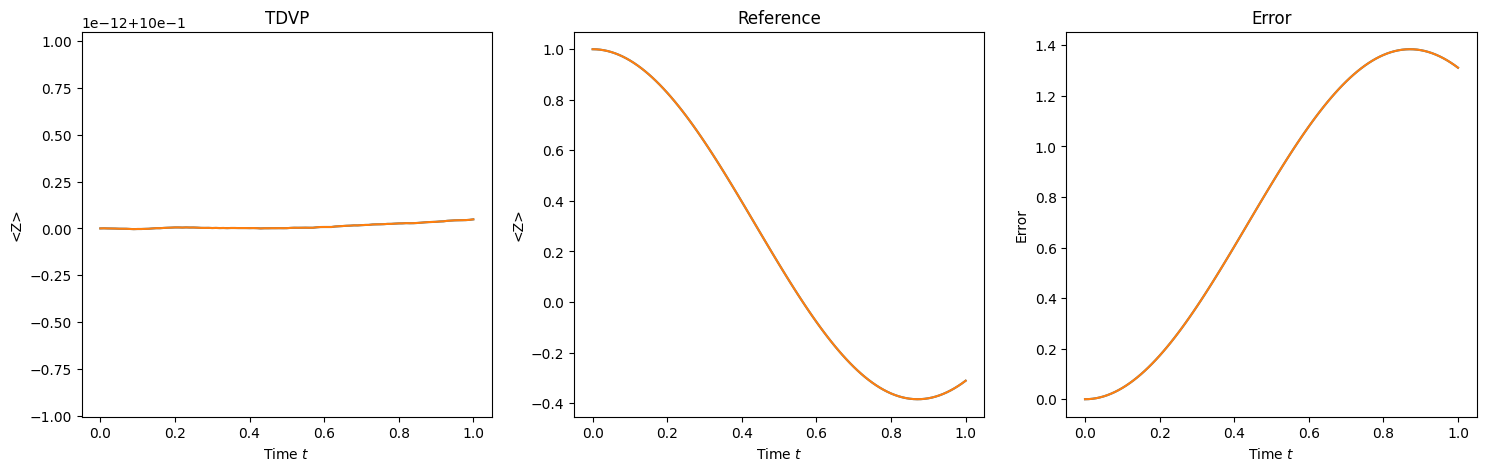

In [18]:
fig2, axs2 = plt.subplots(1,3, sharex=True, figsize=(18,5))
axs2[0].plot(times, tdvp_results_2_site_0)
axs2[0].plot(times, tdvp_results_2_site_1)
axs2[0].set_xlabel("Time $t$")
axs2[0].set_ylabel("<Z>")
axs2[0].set_title("TDVP")

axs2[1].plot(times, ref_results_2_site_0)
axs2[1].plot(times, ref_results_2_site_1)
axs2[1].set_xlabel("Time $t$")
axs2[1].set_ylabel("<Z>")
axs2[1].set_title("Reference")

axs2[2].plot(times, np.abs(ref_results_2_site_0 - tdvp_results_2_site_0))
axs2[2].plot(times, np.abs(ref_results_2_site_1 - tdvp_results_2_site_1))
axs2[2].set_xlabel("Time $t$")
axs2[2].set_ylabel("Error")
axs2[2].set_title("Error")

plt.show()

The error is large, notably because we set the bond dimension to $1$, which is smaller than required. We repeat the process with bond dimension $2$:

In [19]:
mps2 = ptn.MatrixProductState.constant_product_state(0,2,num_sites,
                                                    bond_dimensions=[2])
tdvp2 = ptn.FirstOrderOneSiteTDVP(mps2,ham_ttno_2_site,
                                  time_step_size,final_time,
                                  operators_2_site)
tdvp2.run(evaluation_time=eval_time,pgbar=True)

100%|██████████| 1001/1001 [00:01<00:00, 746.26it/s]


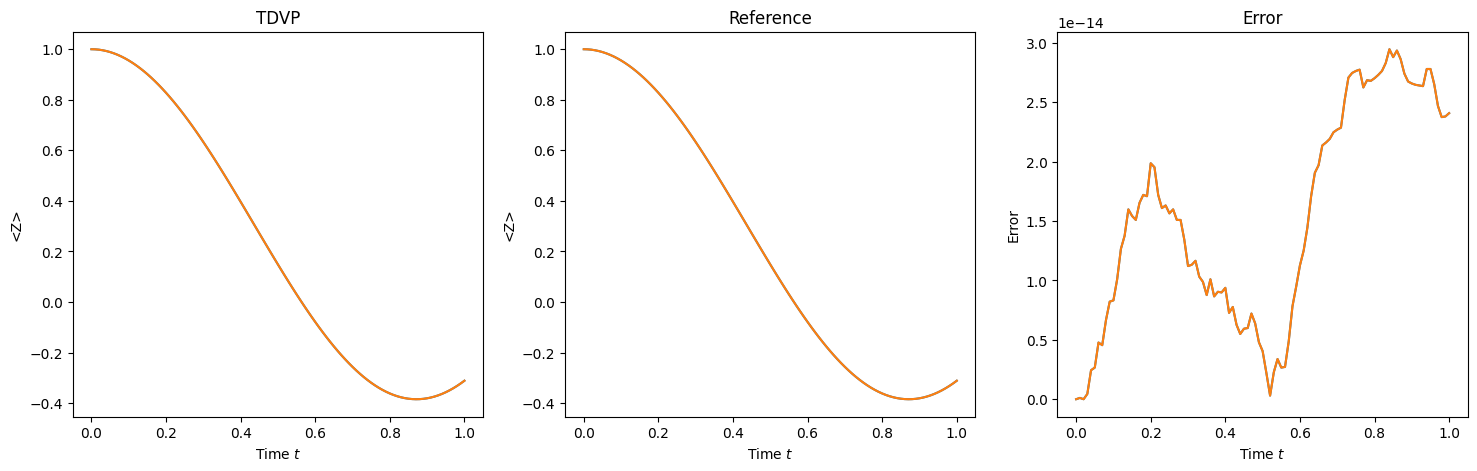

In [20]:
tdvp2_results_2_site_0 = np.real(tdvp2.results[0,:])
tdvp2_results_2_site_1 = np.real(tdvp2.results[1,:])
fig2, axs2 = plt.subplots(1,3, sharex=True, figsize=(18,5))
axs2[0].plot(times, tdvp2_results_2_site_0)
axs2[0].plot(times, tdvp2_results_2_site_1)
axs2[0].set_xlabel("Time $t$")
axs2[0].set_ylabel("<Z>")
axs2[0].set_title("TDVP")

axs2[1].plot(times, ref_results_2_site_0)
axs2[1].plot(times, ref_results_2_site_1)
axs2[1].set_xlabel("Time $t$")
axs2[1].set_ylabel("<Z>")
axs2[1].set_title("Reference")

axs2[2].plot(times, np.abs(ref_results_2_site_0 - tdvp2_results_2_site_0))
axs2[2].plot(times, np.abs(ref_results_2_site_1 - tdvp2_results_2_site_1))
axs2[2].set_xlabel("Time $t$")
axs2[2].set_ylabel("Error")
axs2[2].set_title("Error")

plt.show()

We can clearly see a significant drop in the error.

# TDVP with MPS: Multi-Qubit system evolving under Heisenberg Hamiltonian
This time we consider the Heisenberg like Hamiltonian on $N$-many qubits given by
$$
H = -J \sum_{i=0}^{N-2}X_i X_{i+1} -g \sum_{i=0}^{N-1} Z_i,
$$
where $X_i$ and $Z_i$ are the Pauli operators acting on qubit $i$. We start in the zero state
$$
\ket{\psi} = \bigotimes_{i=0}^{N-1} \ket{0}_i.
$$

In [21]:
num_sites = 7

In [22]:
mps = ptn.MatrixProductState.constant_product_state(0,2,num_sites,root_site=3)

In [23]:
interaction_terms = [ptn.TensorProduct({"site"+str(site): "mJX","site"+str(site+1): "X"})
                     for site in range(num_sites-1)]
single_site_terms = [ptn.TensorProduct({"site"+str(i): "mgZ"}) for i in range(num_sites)]
terms = interaction_terms
terms.extend(single_site_terms)
conversion_dict = {"mJX": mJ * X,
                   "X": X,
                   "mgZ": mg * Z,
                   "I2": np.eye(2)}

In [24]:
hamiltonian = ptn.Hamiltonian(terms, conversion_dict)
hamiltonian = hamiltonian.pad_with_identities(mps)
for term in hamiltonian.terms:
    print(term)

{'site0': 'mJX', 'site1': 'X', 'site3': 'I2', 'site2': 'I2', 'site4': 'I2', 'site5': 'I2', 'site6': 'I2'}
{'site1': 'mJX', 'site2': 'X', 'site3': 'I2', 'site0': 'I2', 'site4': 'I2', 'site5': 'I2', 'site6': 'I2'}
{'site2': 'mJX', 'site3': 'X', 'site1': 'I2', 'site0': 'I2', 'site4': 'I2', 'site5': 'I2', 'site6': 'I2'}
{'site3': 'mJX', 'site4': 'X', 'site2': 'I2', 'site1': 'I2', 'site0': 'I2', 'site5': 'I2', 'site6': 'I2'}
{'site4': 'mJX', 'site5': 'X', 'site3': 'I2', 'site2': 'I2', 'site1': 'I2', 'site0': 'I2', 'site6': 'I2'}
{'site5': 'mJX', 'site6': 'X', 'site3': 'I2', 'site2': 'I2', 'site1': 'I2', 'site0': 'I2', 'site4': 'I2'}
{'site0': 'mgZ', 'site3': 'I2', 'site2': 'I2', 'site1': 'I2', 'site4': 'I2', 'site5': 'I2', 'site6': 'I2'}
{'site1': 'mgZ', 'site3': 'I2', 'site2': 'I2', 'site0': 'I2', 'site4': 'I2', 'site5': 'I2', 'site6': 'I2'}
{'site2': 'mgZ', 'site3': 'I2', 'site1': 'I2', 'site0': 'I2', 'site4': 'I2', 'site5': 'I2', 'site6': 'I2'}
{'site3': 'mgZ', 'site2': 'I2', 'site1': 'I

In [25]:
ham_ttno = ptn.TTNO.from_hamiltonian(hamiltonian, mps)
operators = [ptn.TensorProduct({"site"+str(i): Z}) for i in range(num_sites)]
for operator in operators:
    print(operator)

{'site0': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}
{'site1': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}
{'site2': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}
{'site3': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}
{'site4': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}
{'site5': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}
{'site6': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}


In [26]:
bond_dimensions = [6*[1],
                   6*[2],
                   [2,3,3,3,3,2],
                   [2,4,4,4,4,2],
                   [2,4,5,5,4,2],
                   [2,4,5,5,4,2],
                   [2,4,6,6,4,2],
                   [2,4,7,7,4,3],
                   [2,4,8,8,4,2]]

In [27]:
tdvps = []
for bond_dimension in bond_dimensions:
    mps = ptn.MatrixProductState.constant_product_state(0,2,num_sites,
                                                        root_site=3,
                                                        bond_dimensions=bond_dimension)
    tdvp = ptn.FirstOrderOneSiteTDVP(mps,ham_ttno,
                                    time_step_size,final_time,
                                    operators)
    tdvp.run(evaluation_time=eval_time,pgbar=True)
    tdvps.append(tdvp)

  2%|▏         | 17/1001 [00:00<00:06, 161.95it/s]

100%|██████████| 1001/1001 [00:12<00:00, 82.64it/s]


In [28]:
# Sanity Checks
real = True
for tdvp in tdvps:
    real = real and tdvp.results_real()
real

True

In [29]:
times = tdvps[0].times()
results = [tdvp.operator_results(realise=True) for tdvp in tdvps]

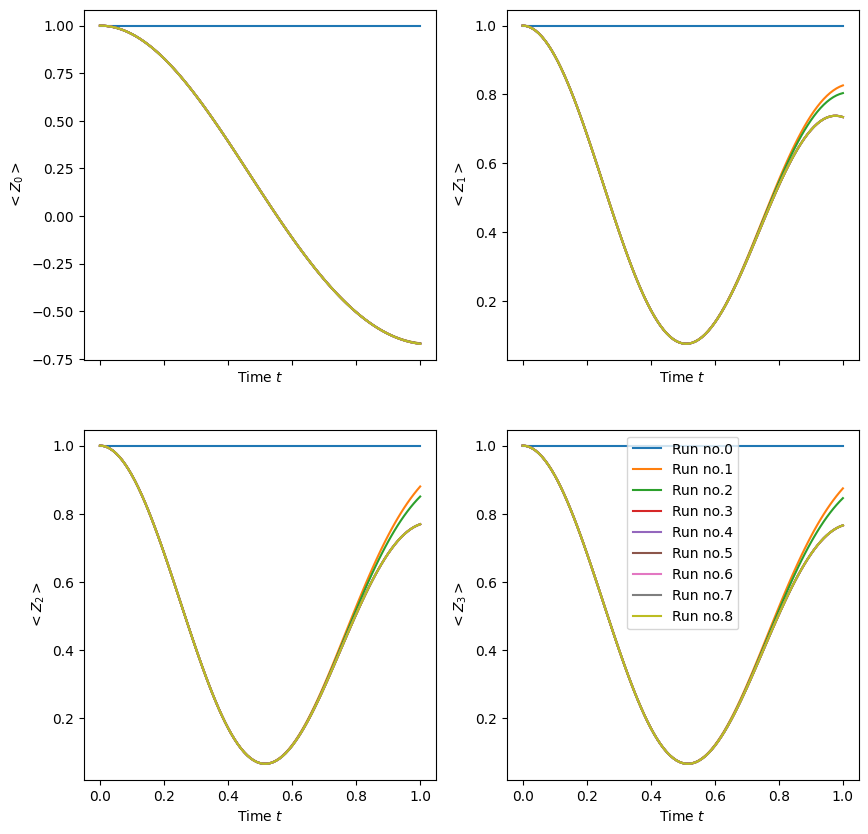

In [30]:
fig3, axs3 = plt.subplots(2,2,figsize=(10,10),sharex=True)

for i in range(len(bond_dimensions)):
    axs3[0,0].plot(times, results[i][0])
axs3[0,0].set_xlabel("Time $t$")
axs3[0,0].set_ylabel("$<Z_0>$")

for i in range(len(bond_dimensions)):
    axs3[0,1].plot(times, results[i][1])
axs3[0,1].set_xlabel("Time $t$")
axs3[0,1].set_ylabel("$<Z_1>$")

for i in range(len(bond_dimensions)):
    axs3[1,0].plot(times, results[i][2])
axs3[1,0].set_xlabel("Time $t$")
axs3[1,0].set_ylabel("$<Z_2>$")

for i in range(len(bond_dimensions)):
    axs3[1,1].plot(times, results[i][3], label="Run no." + str(i))
axs3[1,1].set_xlabel("Time $t$")
axs3[1,1].set_ylabel("$<Z_3>$")

plt.legend()
plt.show()

Let's do the reference computation.

In [31]:
print(ham_ttno.nodes.keys())
hamiltonian_matrix = ham_ttno.completely_contract_tree(to_copy=True).root[1]
hamiltonian_matrix = np.transpose(hamiltonian_matrix,(6,4,2,0,8,10,12,7,5,3,1,9,11,13))
hamiltonian_matrix = np.reshape(hamiltonian_matrix,(2**num_sites,2**num_sites))
init_state = np.zeros(2**num_sites)
init_state[0] = 1
operators = num_sites*[np.asarray(1)]
for site in range(num_sites):
    for i, operator in enumerate(operators):
        if site == i:
            operators[i] = np.kron(operator, Z)
        else:
            operators[i] = np.kron(operator, np.eye(2))

dict_keys(['site3', 'site2', 'site1', 'site0', 'site4', 'site5', 'site6'])


In [32]:
exact_evo = ptn.ExactTimeEvolution(init_state, hamiltonian_matrix,
                                   time_step_size, final_time,
                                   operators)
exact_evo.run(evaluation_time=eval_time)
# Sanity checks
print(exact_evo.results_real())
print(exact_evo.operator_results().shape)

100%|██████████| 1001/1001 [00:00<00:00, 19812.09it/s]

True
(7, 101)


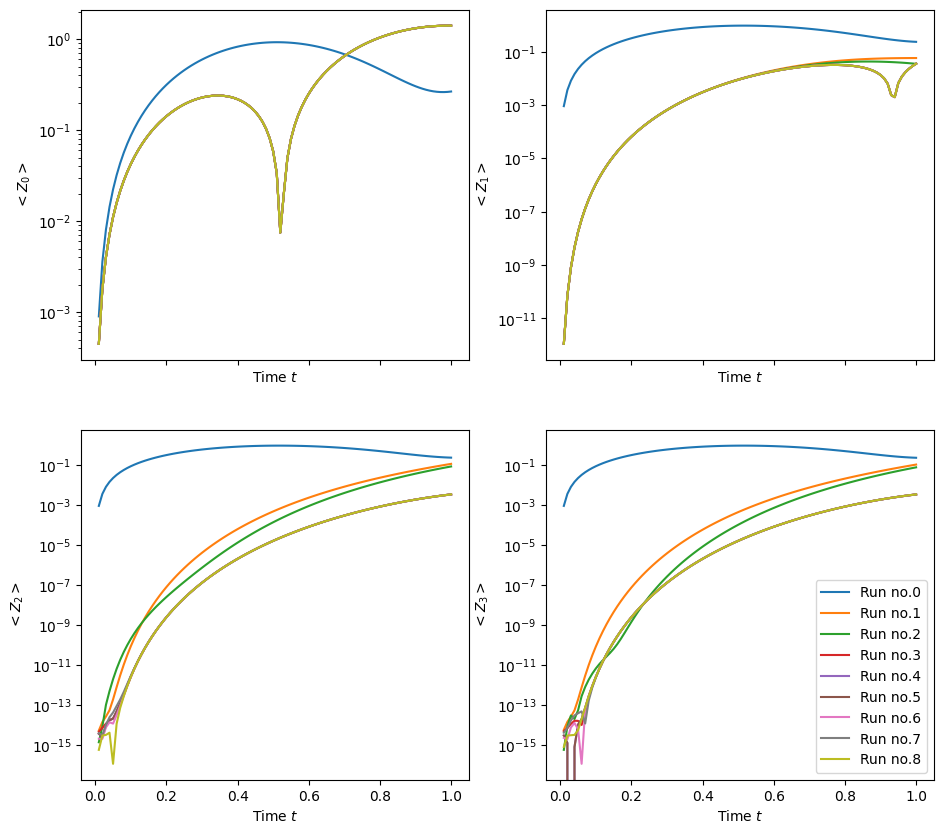

In [33]:
times = exact_evo.times()
ref_results = exact_evo.operator_results(realise=True)

fig4, axs4 = plt.subplots(2,2,figsize=(11,10),sharex=True)

for i in range(0,len(bond_dimensions)):
    axs4[0,0].semilogy(times[1:], np.abs(results[i][0]-ref_results[1])[1:])
axs4[0,0].set_xlabel("Time $t$")
axs4[0,0].set_ylabel("$<Z_0>$")

for i in range(0,len(bond_dimensions)):
    axs4[0,1].semilogy(times[1:], np.abs(results[i][1]-ref_results[2])[1:])
axs4[0,1].set_xlabel("Time $t$")
axs4[0,1].set_ylabel("$<Z_1>$")

for i in range(0,len(bond_dimensions)):
    axs4[1,0].semilogy(times[1:], np.abs(results[i][2]-ref_results[3])[1:])
axs4[1,0].set_xlabel("Time $t$")
axs4[1,0].set_ylabel("$<Z_2>$")

for i in range(0,len(bond_dimensions)):
    axs4[1,1].semilogy(times[1:], np.abs(results[i][3]-ref_results[4])[1:], label="Run no." + str(i))
axs4[1,1].set_xlabel("Time $t$")
axs4[1,1].set_ylabel("$<Z_3>$")

plt.legend()
plt.show()

We can clearly see that the result improves for an increasing bond dimension. Furthermore, we find that the accuracy reduces the longer the simulation is run. Both are as one would expect.

# 2nd-order TDVP with MPS 
## Two Qubit system evolving under Heisenberg Hamiltonian
The TDVP in with a first order Trotter splitting is rather inefficient. We have to recanonicalise our TTNS after every time step. Additionally, we reduce the error in terms of the time step $\delta t$ from $O(\delta t)$ to $O(\delta t^2)$, when using a second order splitting for a comparatively low additional cost.

We will run it with the same Heisenberg model as above.

In [34]:
num_sites = 2

In [35]:
mps2 = ptn.MatrixProductState.constant_product_state(0,2,num_sites,
                                                    bond_dimensions=[2])
tdvp2 = ptn.SecondOrderOneSiteTDVP(mps2,ham_ttno_2_site,
                                   time_step_size,final_time,
                                   operators_2_site)
tdvp2.run(evaluation_time=eval_time,pgbar=True)
# Sanity Checks
print(tdvp2.results_real())
print(tdvp2.operator_results().shape)

  5%|▌         | 55/1001 [00:00<00:01, 545.59it/s]

100%|██████████| 1001/1001 [00:01<00:00, 583.55it/s]

True
(2, 101)


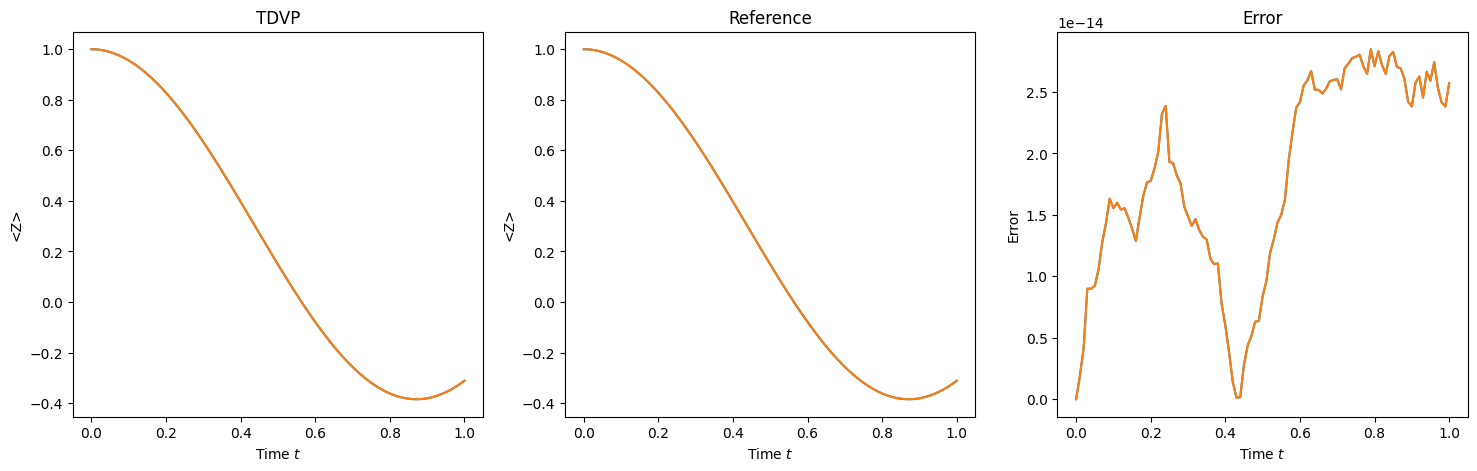

In [36]:
tdvp2_results_2_site_2nd_order = tdvp2.operator_results(realise=True)
tdvp2_results_2_site_2nd_order_0 = tdvp2_results_2_site_2nd_order[0]
tdvp2_results_2_site_2nd_order_1 = tdvp2_results_2_site_2nd_order[1]
fig2, axs2 = plt.subplots(1,3, sharex=True, figsize=(18,5))
axs2[0].plot(times, tdvp2_results_2_site_2nd_order_0)
axs2[0].plot(times, tdvp2_results_2_site_2nd_order_1)
axs2[0].set_xlabel("Time $t$")
axs2[0].set_ylabel("<Z>")
axs2[0].set_title("TDVP")

axs2[1].plot(times, ref_results_2_site_0)
axs2[1].plot(times, ref_results_2_site_1)
axs2[1].set_xlabel("Time $t$")
axs2[1].set_ylabel("<Z>")
axs2[1].set_title("Reference")

axs2[2].plot(times, np.abs(ref_results_2_site_0 - tdvp2_results_2_site_2nd_order_0))
axs2[2].plot(times, np.abs(ref_results_2_site_1 - tdvp2_results_2_site_2nd_order_1))
axs2[2].set_xlabel("Time $t$")
axs2[2].set_ylabel("Error")
axs2[2].set_title("Error")

plt.show()

Let us compare the error of both orders.

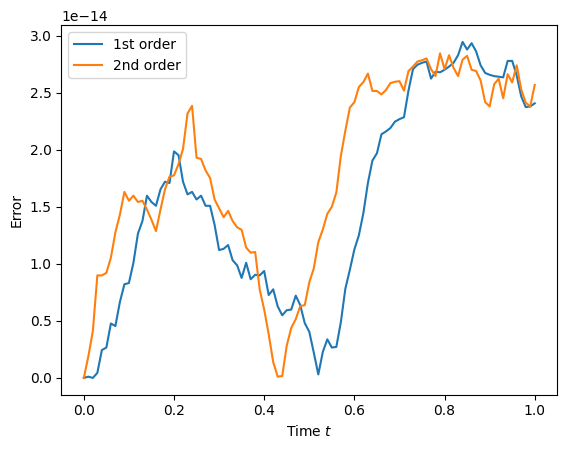

In [37]:
fig_order_comparison_2_site = plt.figure()
plt.ylabel("Error")
plt.xlabel("Time $t$")
plt.plot(times, np.abs(ref_results_2_site_0 - tdvp2_results_2_site_0),
                       label="1st order")
plt.plot(times, np.abs(ref_results_2_site_0 - tdvp2_results_2_site_2nd_order_0),
         label="2nd order")
plt.legend()
plt.show()

## Multi-Qubit system evolving under Heisenberg Hamiltonian
We will run it with the same Heisenberg model as above.

In [38]:
num_sites = 7
mps = ptn.MatrixProductState.constant_product_state(0,2,num_sites,root_site=3)

In [39]:
interaction_terms = [ptn.TensorProduct({"site"+str(site): "mJX","site"+str(site+1): "X"})
                     for site in range(num_sites-1)]
single_site_terms = [ptn.TensorProduct({"site"+str(i): "mgZ"}) for i in range(num_sites)]
terms = interaction_terms
terms.extend(single_site_terms)
conversion_dict = {"mJX": mJ * X,
                   "X": X,
                   "mgZ": mg * Z,
                   "I2": np.eye(2)}

In [40]:
hamiltonian = ptn.Hamiltonian(terms, conversion_dict)
hamiltonian = hamiltonian.pad_with_identities(mps)
ham_ttno = ptn.TTNO.from_hamiltonian(hamiltonian, mps)
operators = [ptn.TensorProduct({"site"+str(i): Z}) for i in range(num_sites)]

In [41]:
bond_dimensions = [6*[1],
                   6*[2],
                   [2,3,3,3,3,2],
                   [2,4,4,4,4,2],
                   [2,4,5,5,4,2],
                   [2,4,5,5,4,2],
                   [2,4,6,6,4,2],
                   [2,4,7,7,4,3],
                   [2,4,8,8,4,2]]

In [42]:
tdvps = []
for bond_dimension in bond_dimensions:
    mps = ptn.MatrixProductState.constant_product_state(0,2,num_sites,
                                                        root_site=3,
                                                        bond_dimensions=bond_dimension)
    tdvp = ptn.SecondOrderOneSiteTDVP(mps,ham_ttno,
                                      time_step_size,final_time,
                                      operators)
    tdvp.run(evaluation_time=eval_time,pgbar=True)
    tdvps.append(tdvp)

  1%|▏         | 13/1001 [00:00<00:08, 120.94it/s]

100%|██████████| 1001/1001 [00:21<00:00, 47.03it/s]


In [43]:
# All expectation values are real
real = True
for tdvp in tdvps:
    real = real and tdvp.results_real()
real

True

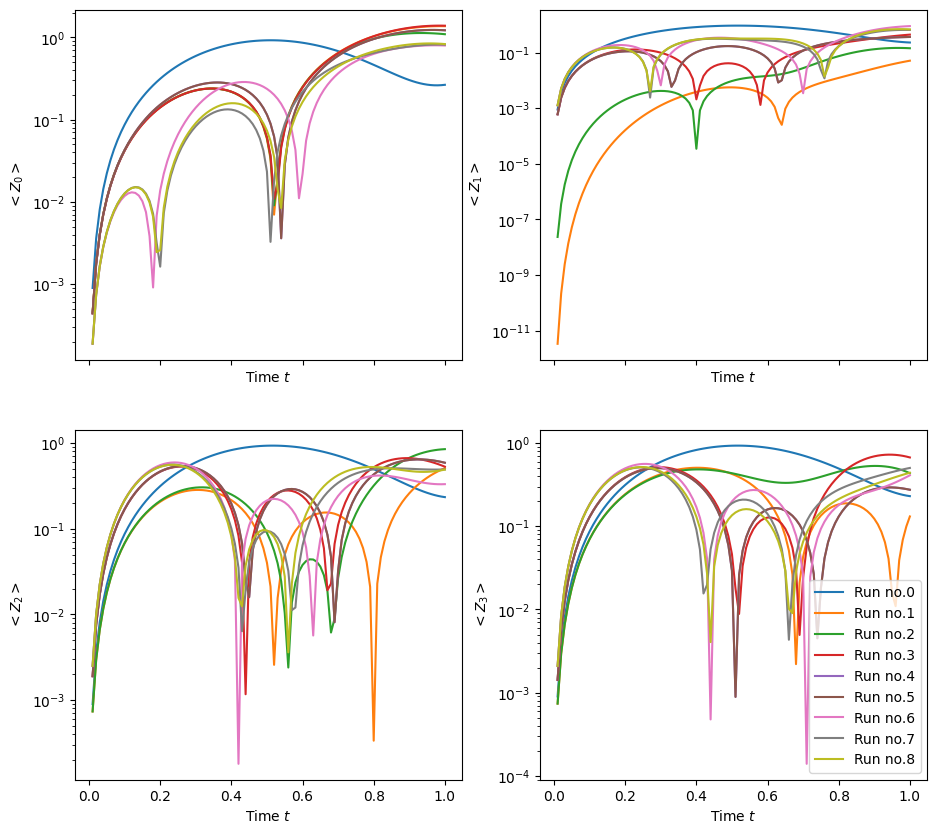

In [44]:
times = tdvps[0].times()
results = [tdvp.operator_results(realise=True) for tdvp in tdvps]
fig5, axs5 = plt.subplots(2,2,figsize=(11,10),sharex=True)

for i in range(0,len(bond_dimensions)):
    axs5[0,0].semilogy(times[1:], np.abs(results[i][0]-ref_results[1])[1:])
axs5[0,0].set_xlabel("Time $t$")
axs5[0,0].set_ylabel("$<Z_0>$")

for i in range(0,len(bond_dimensions)):
    axs5[0,1].semilogy(times[1:], np.abs(results[i][1]-ref_results[2])[1:])
axs5[0,1].set_xlabel("Time $t$")
axs5[0,1].set_ylabel("$<Z_1>$")

for i in range(0,len(bond_dimensions)):
    axs5[1,0].semilogy(times[1:], np.abs(results[i][2]-ref_results[3])[1:])
axs5[1,0].set_xlabel("Time $t$")
axs5[1,0].set_ylabel("$<Z_2>$")

for i in range(0,len(bond_dimensions)):
    axs5[1,1].semilogy(times[1:], np.abs(results[i][3]-ref_results[4])[1:], label="Run no." + str(i))
axs5[1,1].set_xlabel("Time $t$")
axs5[1,1].set_ylabel("$<Z_3>$")

plt.legend()
plt.show()

In [45]:
print(tdvp.update_path)
print(tdvp.backwards_update_path)
print(tdvp.orthogonalization_path)
print(tdvp.backwards_orth_path)

['site0', 'site1', 'site2', 'site3', 'site4', 'site5', 'site6']
['site6', 'site5', 'site4', 'site3', 'site2', 'site1', 'site0']
[['site1'], ['site2'], ['site3'], ['site4'], ['site5'], ['site6']]
[['site5'], ['site4'], ['site3'], ['site2'], ['site1'], ['site0']]
